In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Species

In [2]:
df_species = pd.read_parquet('../processed_data/species_coverage.parquet')

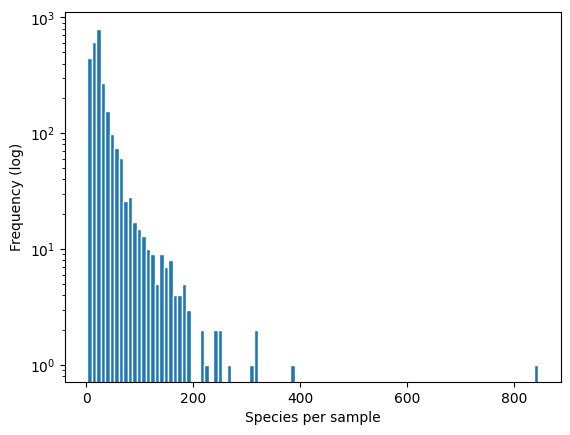

In [3]:
# Species per Sample
count_species_sample = (df_species > 0).sum(1).sort_values(ascending=False)
plt.hist(count_species_sample.values, edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Species per sample')
plt.yscale('log')
plt.show()

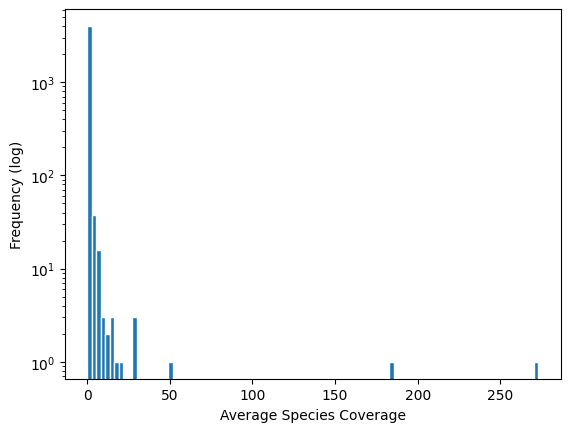

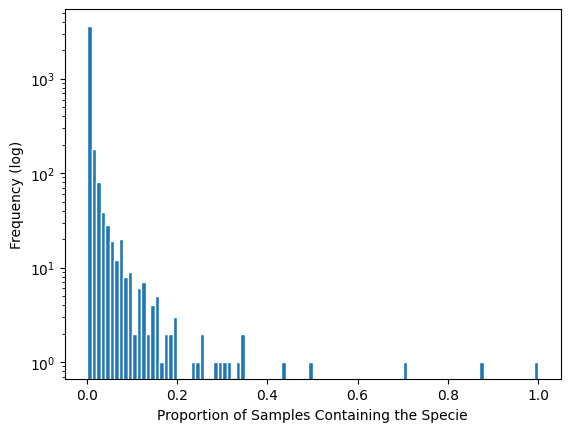

In [4]:
# Average Species Coverage
sum_species_coverage = df_species.sum(0).sort_values(ascending=False)
plt.hist(sum_species_coverage.values/df_species.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Average Species Coverage')
plt.yscale('log')
plt.show()

# Average Species Count
count_species = (df_species > 0).sum(0).sort_values(ascending=False)
plt.hist(count_species.values / df_species.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Proportion of Samples Containing the Specie')
plt.yscale('log')
plt.show()

In [5]:
count_threshold = 100

print(f'# Species that appear in less than {count_threshold} samples: {int((count_species < count_threshold).sum())}')

# Species that appear in less than 100 samples: 3916


# Genes

In [6]:
df_genes = pd.read_parquet('../processed_data/gene_coverage.parquet')
df_genes = df_genes.set_index("Sample")

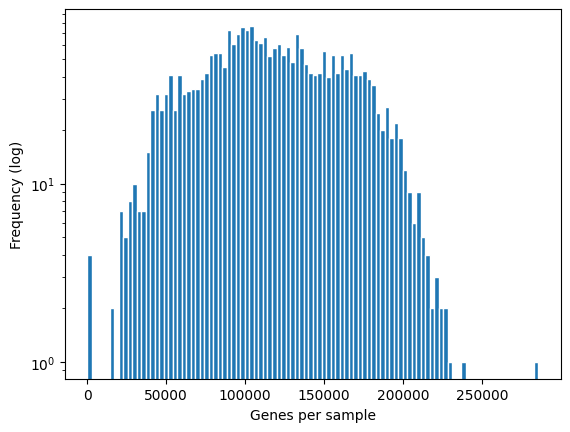

In [7]:
# Genes per Sample
count_genes_sample = (df_genes > 0).sum(1).sort_values(ascending=False)
plt.hist(count_genes_sample.values, edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Genes per sample')
plt.yscale('log')
plt.show()

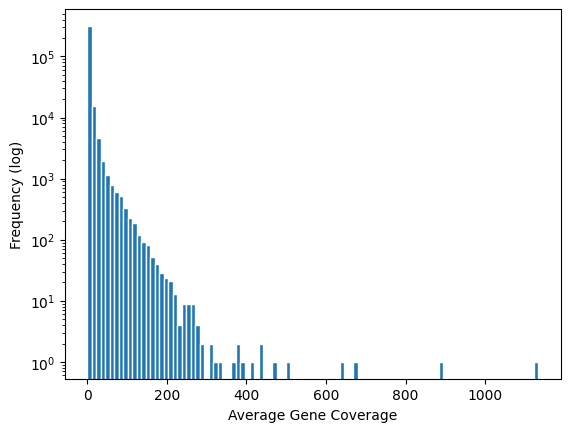

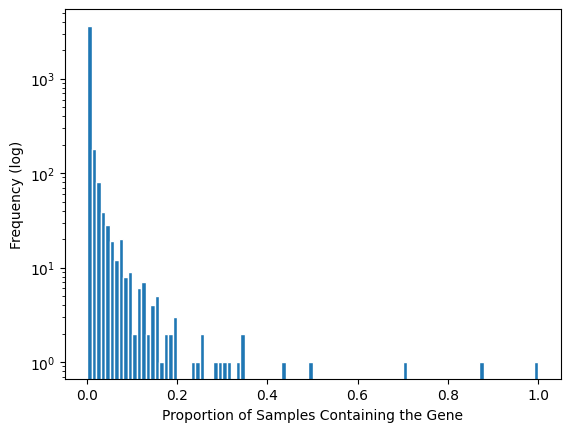

In [8]:
# Average Gene Coverage
sum_species_coverage = df_genes.sum(0).sort_values(ascending=False)
plt.hist(sum_species_coverage.values/df_genes.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Average Gene Coverage')
plt.yscale('log')
plt.show()

# Average Gene Count
count_genes = (df_genes > 0).sum(0).sort_values(ascending=False)
plt.hist(count_species.values / df_genes.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Proportion of Samples Containing the Gene')
plt.yscale('log')
plt.show()

In [9]:
count_threshold = 100

print(f'# Genes that appear in less than {count_threshold} samples: {int((count_genes < count_threshold).sum())}')

# Genes that appear in less than 100 samples: 64639
